# Implement Levi Hassner Model (CVPR2015)

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
print(tf.__version__)

/mnt/local/yuxin/anaconda3/envs/gender/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-11-09 13:05:46.165936: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


In [2]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

2022-11-09 13:05:48.218719: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-09 13:05:48.220047: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-09 13:05:48.309978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 13:05:48.310585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-09 13:05:48.310664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
device_lib.list_local_devices()

2022-11-09 13:05:55.356063: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17388184904451874998,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10290305472
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17474467833993411392
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10552922624
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11296418921680913182
 physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5"]

2022-11-09 13:05:55.356500: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-09 13:05:55.512572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 13:05:55.512916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-09 13:05:55.512964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 13:05:55.513243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00

# Preprocess Adience Dataset

In [4]:
# load data
ADIENCE_PATH = './Adience'
print(os.listdir(path=ADIENCE_PATH))

all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )

['AdienceBenchmarkGenderAndAgeClassification', 'faces', 'fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt', '__MACOSX']


In [5]:
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [6]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


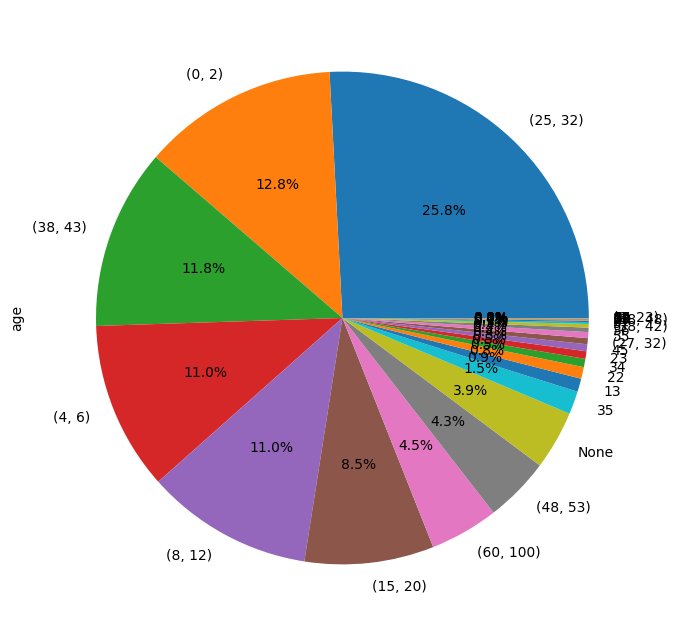

In [7]:
# pie_graph
plt.figure(1, figsize=(8,8))
total_data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

f    9372
m    8120
u    1099
Name: gender, dtype: int64


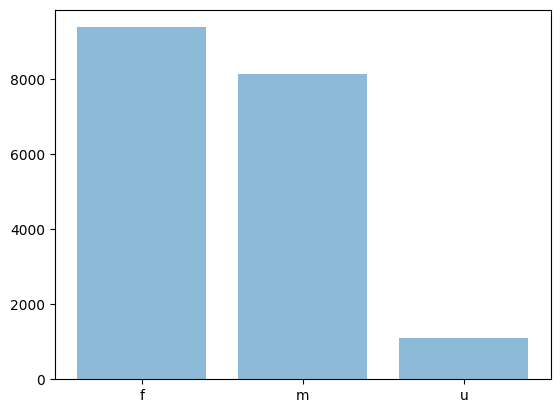

In [8]:
# bar chart
gender = ['f','m','u']
plt.bar(gender, total_data.gender.value_counts(), align='center', alpha=0.5)
print(total_data.gender.value_counts())
plt.show()

In [9]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()

img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       19370 non-null  object
 1   gender    18591 non-null  object
 2   x         19370 non-null  int64 
 3   y         19370 non-null  int64 
 4   dx        19370 non-null  int64 
 5   dy        19370 non-null  int64 
 6   img_path  19370 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.0+ MB


In [10]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

/tmp/ipykernel_26926/3604610946.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = age_mapping_dict[each]


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [11]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [12]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,./Adience/faces/30601258@N03/coarse_tilt_align...
1,4,1,301,105,640,641,./Adience/faces/30601258@N03/coarse_tilt_align...
2,4,0,2395,876,771,771,./Adience/faces/30601258@N03/coarse_tilt_align...
3,4,1,752,1255,484,485,./Adience/faces/30601258@N03/coarse_tilt_align...
4,4,1,175,80,769,768,./Adience/faces/30601258@N03/coarse_tilt_align...


# Create Dataset

In [13]:
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [14]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    # TODO: np.float
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)


# Create Model
---
## Hyperparameters

In [25]:
batch_size = 1
epochs = 500
target_size = (227, 227) # (64, 64)
input_shape = (227, 227, 3) #(64, 64, 3)

# random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

adam = 0.001
fre = -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch = 256
validation_steps = 256

In [34]:
# calculate schedule drop based on epoch supplied
# paper said drop to 1e-4 when 10k epochs which is equivalent to drop 1e-3 by 10% which is 1e-4
import math

def step_decay(epoch):
    init_lrate = 1e-3 
    drop = 0.1
    epochs_drop = 10000
    lrate = init_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
    
weight_init = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=SEED)

https://github.com/naritapandhe/Gender-Age-Classification-CNN/blob/master/gender/train_and_test_gender.py

https://github.com/dpressel/rude-carnie/blob/master/model.py

In [27]:
# Define baseline model builder
def build_LeviHassner():
    model = keras.models.Sequential()
    
    # conv1: 96 filters, 7x7 kernel, stride=4, valid padding
    # max pooling with 3x3 kernel, stride=2
    # local response normalization
    model.add(Conv2D(96, (7,7), input_shape=input_shape, strides=4, padding='valid', 
                     activation='relu', kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size=(3, 3), strides=2, padding='same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    
    # conv2: 256 filters, 5x5 kernel and relu, padding=same
    # max pooling with 3x3 kernel, stride=2
    # local response normalization
    model.add(Conv2D(256, (5,5), padding='same', activation = 'relu', kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size = (3, 3), strides = 2,padding = 'same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    
    # conv3: 384 filters, 3x3 kernel and relu, padding=same
    # max pooling with 3x3 kernel, stride=2
    model.add(keras.layers.Conv2D(384,(3,3),padding='same',activation='relu',kernel_initializer=weight_init))
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
    
    # flatten
    model.add(Flatten())
    
    # fc1 + dropout
    model.add(Dense(512, activation="relu", kernel_initializer=weight_init))
    model.add(Dropout(0.5))
    
    # fc2 + dropout
    model.add(Dense(512, activation='relu', kernel_initializer=weight_init))
    model.add(Dropout(0.5))
    
    # fc3
    model.add(Dense(1, activation ='sigmoid', kernel_initializer=weight_init))
    
    # compile the model
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 384)      

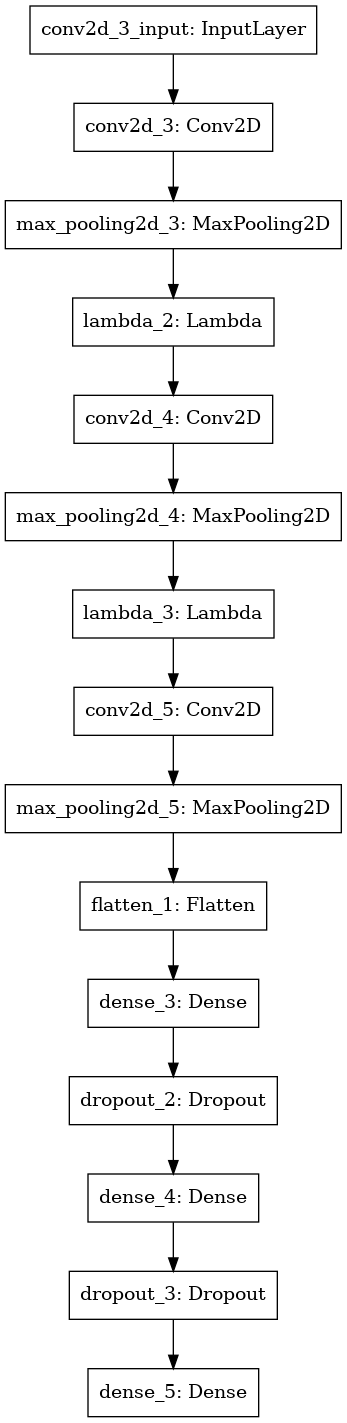

In [28]:
# Visualize the model
from tensorflow.keras.utils import plot_model

model = build_LeviHassner()
model.summary()
plot_model(model)

In [35]:
def get_call_backs():
    """
    lrd = ReduceLROnPlateau(monitor = 'val_loss',
                            patience = patience,
                            verbose = verbose ,
                            factor = factor,
                            min_lr = min_lr)
    """
    lrate = keras.callbacks.LearningRateScheduler(step_decay)
    
    mcp = ModelCheckpoint('model.h5')

    es = EarlyStopping(verbose=verbose, patience=patience)
    
    return [lrate, mcp, es]

In [36]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [37]:
# training
history = model.fit(
    train_images, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, y_test), 
    callbacks=get_call_backs())

2022-11-09 13:42:39.228251: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.


Epoch 1/500
12216/12216 [==============================] - 44s 4ms/step - loss: 0.6875 - accuracy: 0.5383 - val_loss: 0.6300 - val_accuracy: 0.6325
Epoch 2/500
12216/12216 [==============================] - 43s 3ms/step - loss: 0.6197 - accuracy: 0.6525 - val_loss: 0.6358 - val_accuracy: 0.5898
Epoch 3/500
12216/12216 [==============================] - 43s 4ms/step - loss: 0.5981 - accuracy: 0.6724 - val_loss: 0.5482 - val_accuracy: 0.7408
Epoch 4/500
12216/12216 [==============================] - 45s 4ms/step - loss: 0.5385 - accuracy: 0.7214 - val_loss: 0.5093 - val_accuracy: 0.7460
Epoch 5/500
12216/12216 [==============================] - 43s 4ms/step - loss: 0.4822 - accuracy: 0.7688 - val_loss: 0.3937 - val_accuracy: 0.8121
Epoch 6/500
12216/12216 [==============================] - 46s 4ms/step - loss: 0.4110 - accuracy: 0.8059 - val_loss: 0.3721 - val_accuracy: 0.8398
Epoch 7/500
12216/12216 [==============================] - 45s 4ms/step - loss: 0.3579 - accuracy: 0.8378 - val_

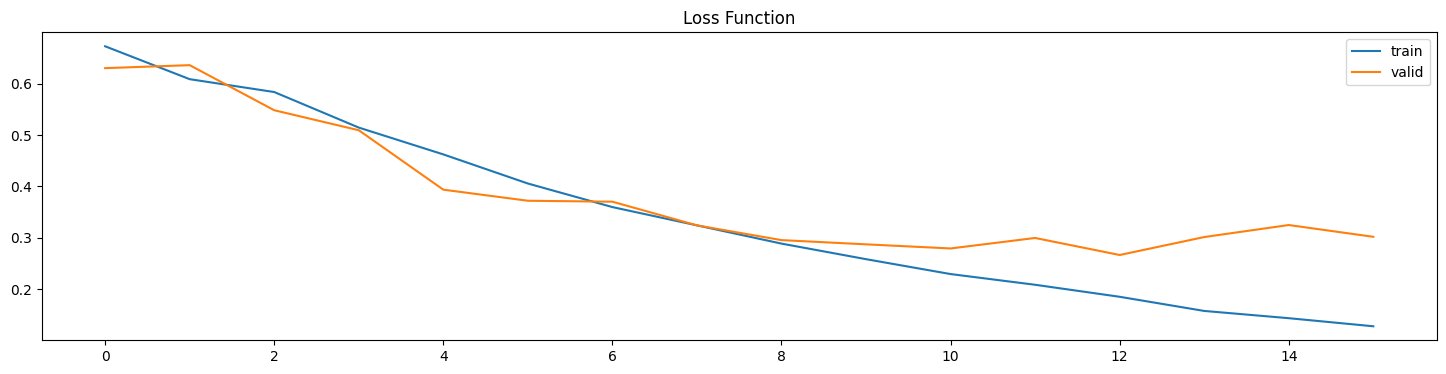

In [38]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

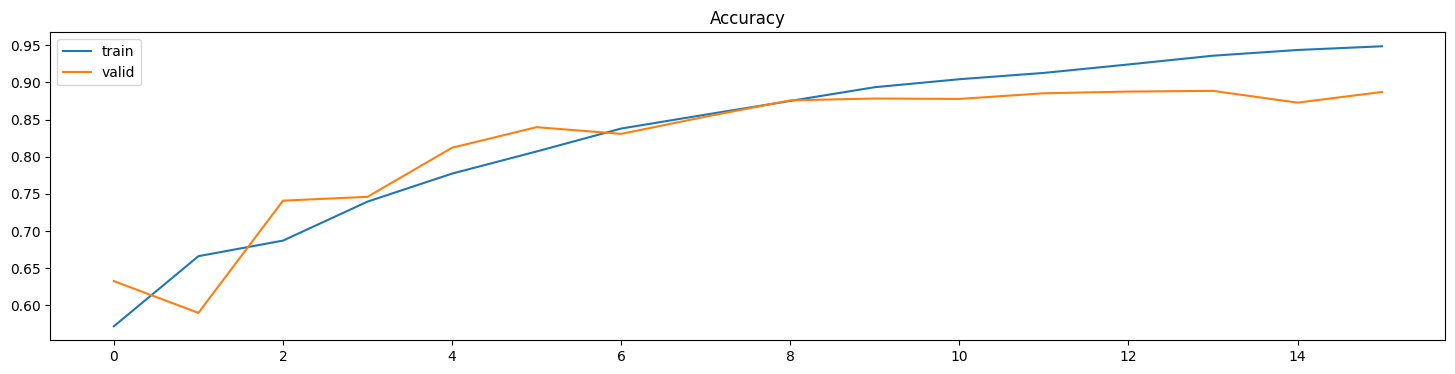

In [40]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [42]:
# test
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

164/164 - 1s - loss: 0.3020 - accuracy: 0.8871
0.8871275782585144
